In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import bin2cell as b2c
print(b2c.__version__)

0.3.3


In [2]:
# import session_info
# session_info.show()

In [3]:
sc.settings.set_figure_params(dpi=80)

In [4]:
os.getcwd()

'/nfs/team205/kk18/notebooks/Foetal/VisiumHD/re-seq_mpp0p3'

# Read the objects

In [5]:
adata_dir = '/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects'
sample_id = 'HEA_FOET14880396'

In [6]:
!ls {adata_dir}

archived-Dec2024_HEA_FOET14880396_b2c.h5ad
cellcharter
HEA_AD14880301_b2c.h5ad
HEA_FOET14880396_8um-bins_filtered.h5ad
HEA_FOET14880396_8um-bins_filtered_lognorm.h5ad
HEA_FOET14880396_b2c_cells_filtered_celltype-selected_lognorm.h5ad
HEA_FOET14880396_b2c_cells_filtered.h5ad
HEA_FOET14880396_b2c_cells_filtered_lognorm.h5ad
HEA_FOET14880396_b2c_cells_filtered_lognorm_morpho_obs.csv
HEA_FOET14880396_b2c_cells.h5ad
HEA_FOET14880396_b2c.h5ad
HEA_FOET14880397_b2c.h5ad
subsets


In [7]:
adata = sc.read_h5ad(f'{adata_dir}/{sample_id}_b2c.h5ad') # read 2um object which has b2c cell grouping - see tutorial - https://nbviewer.org/github/Teichlab/bin2cell/blob/main/notebooks/demo.ipynb 
cdata = sc.read_h5ad(f'{adata_dir}/{sample_id}_b2c_cells_filtered_lognorm.h5ad') # read b2c object
anno_df = pd.read_csv(f'/nfs/team205/kk18/notebooks/Foetal/VisiumHD/re-seq_mpp0p3/loupe_annotation/{sample_id}_HistologicalAnnotation.csv',index_col=0)
anno = 'HistologicalAnnotation'
cell_grouping = 'labels_joint'

In [8]:
adata

AnnData object with n_obs × n_vars = 5001851 × 18051
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he_0p01', 'labels_he_0p03', 'labels_he_0p05', 'labels_he_0p1', 'labels_he_default', 'labels_he_sel', 'labels_he_expanded_1', 'labels_he_expanded_2', 'labels_he_expanded_3', 'labels_he_expanded_4', 'labels_he_expanded_sel', 'labels_gex_0p005', 'labels_gex_0p01', 'labels_gex_0p03', 'labels_gex_0p05', 'labels_gex_sel', 'labels_joint', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'bin2cell', 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

# Import annotations from loupe browser

In [9]:
def map_loupe_to_b2c(
        adata,
        cdata,
        anno_df,
        anno,
        cell_grouping = 'labels_he_expanded', 
        ):
     

    # Calculate the binned row and column indices in adata
    adata.obs['binned_8_row'] = adata.obs['array_row'] // 4
    adata.obs['binned_8_col'] = adata.obs['array_col'] // 4

    # Create a combined index in adata and set it as the index
    adata.obs['mapping_index_08'] = 's_008um_' + adata.obs['binned_8_row'].astype(str).str.zfill(5) + '_' + adata.obs['binned_8_col'].astype(str).str.zfill(5) + '-1'
    adata.obs['mapping_index_08'].value_counts() # most should have 16 but there are some on the tissue edge that actually have less due to partial overlap 

    # read annotations from df and map to the 2um object 
    print('annotations to map:')
    print(anno_df.head(5))
    mapping_dict = pd.Series(anno_df[anno].values,index=anno_df.index).to_dict()
    adata.obs[anno] = adata.obs['mapping_index_08'].map(mapping_dict) # update 2um object 

    # assign annotation to cells by pandas.Series.mode(). The mode is the value that appears most often which captures the most frequent annotation for that cell from 2um data
    filtered_data = adata.obs[(adata.obs[cell_grouping] != 0) & adata.obs[anno].notna()]
    cell_annotation = (
        filtered_data.groupby(cell_grouping)[anno]
        .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    )
    cell_annotation.index = cell_annotation.index.astype('str')
    cdata.obs[anno] = cdata.obs.index.map(cell_annotation).astype('category') # label cells 
    print('Annotations in b2c object:')
    print(cdata.obs[anno].value_counts())

map_loupe_to_b2c(adata,
                 cdata,
                 anno_df,
                 anno,
                 cell_grouping)

annotations to map:
                                      HistologicalAnnotation
Barcode                                                     
s_008um_00301_00321-1                                 Valves
s_008um_00602_00290-1  Great vessel - Pulmonary artery Right
s_008um_00377_00750-1                              Ventricle
s_008um_00383_00696-1                              Ventricle
s_008um_00526_00291-1                   Great vessel - Aorta
Annotations in b2c object:
HistologicalAnnotation
Ventricle                                                     64624
Atrium                                                        17355
Valves                                                         6435
Great vessel - Pulmonary artery Left and Ductus arteriosus     4746
Great vessel - Pulmonary artery Right                          2838
Coronary vessel                                                2752
Great vessel - Aorta                                           2564
Name: count, dtype: int64


# Plot

In [17]:
annotations_to_plot = list(set(anno_df['HistologicalAnnotation'].dropna()))
group_col = 'HistologicalAnnotation'
len(annotations_to_plot)

7

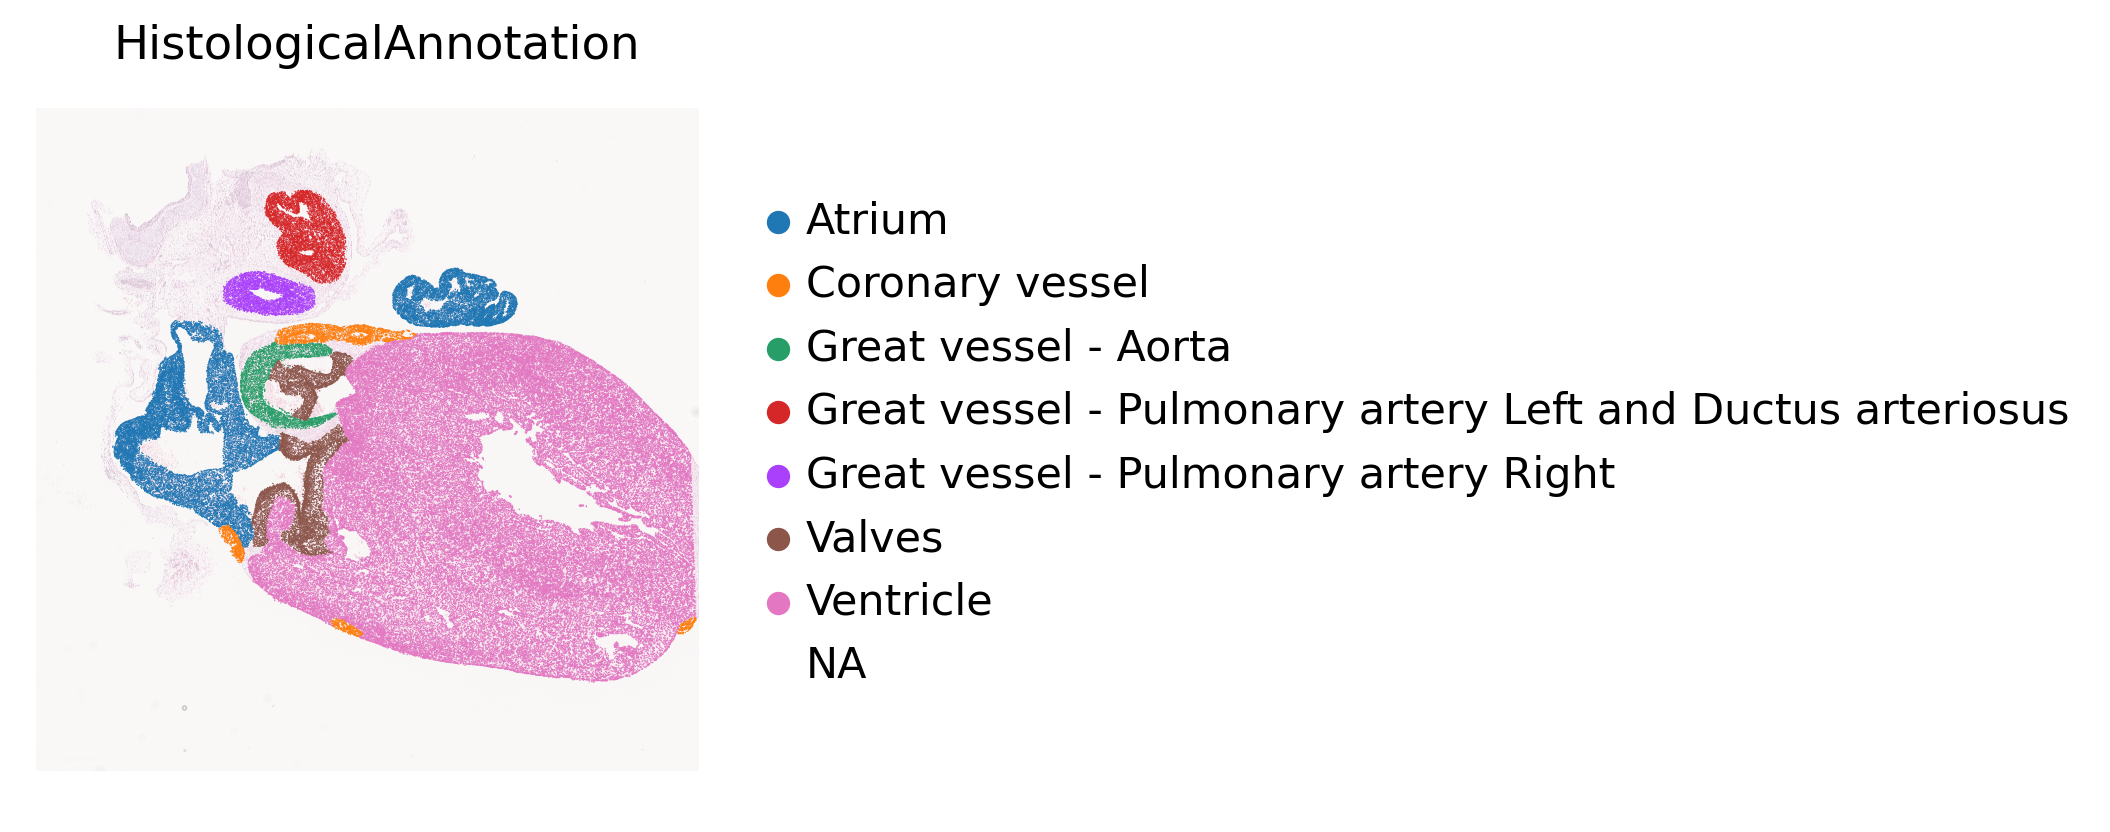

In [25]:
sc.settings.set_figure_params(dpi=120)
sc.pl.spatial(cdata, 
                  color=group_col, 
                  img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer",
                  size=1.5,alpha_img=0.3,
                  frameon=False,
                 )

In [ ]:
fig,axs=plt.subplots(nrows=1,ncols=6,figsize=(24,4))
# Flatten the axs array for easier iteration in case of multiple rows and columns
axs_flat = axs.flatten()

for i,annotation in enumerate(annotations_to_plot):
    ad = cdata.copy()
    # update colors
    # get color in cdata
    ind = list(ad.obs[group_col].cat.categories).index(annotation)
    ad.uns[f'{group_col}_colors'][ind] = 'greenyellow'
    # plot
    sc.pl.spatial(ad, 
                  color=group_col, groups=annotation,
                  img_key="0.3_mpp_150_buffer", basis="spatial_cropped_150_buffer",
                  size=7,legend_loc=None,
                  frameon=False,title=annotation,
                  show=False, ax=axs_flat[i],
                 )
# Turn off any remaining subplots
for j in range(len(annotations_to_plot), len(axs_flat)):
    fig.delaxes(axs_flat[j])

# fig.suptitle('Main Title for the Figure')
fig.tight_layout()

# Save cdata

In [21]:
cdata

AnnData object with n_obs × n_vars = 129803 × 18047
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'fine_grain_4Jan2025', 'HistologicalAnnotation'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'HistologicalAnnotation_colors', 'celltypist_coarse2midmod_colors', 'celltypist_coarse_colors

In [22]:
cdata.write(f'{adata_dir}/{sample_id}_b2c_cells_filtered_lognorm.h5ad')
cdata

AnnData object with n_obs × n_vars = 129803 × 18047
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'fine_grain_4Jan2025', 'HistologicalAnnotation'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'HistologicalAnnotation_colors', 'celltypist_coarse2midmod_colors', 'celltypist_coarse_colors

* Run cellcharter with VisiumHD data
* Predict tissue label per cellcharter group (TissueTypist, with low res, large dataset)
* annotate niches --> cell type localisation, eg SAN
* --> summarise the workflow as figure